In [1]:
import heapq
import datetime

# Check platform.
import platform
if platform.machine() not in ['x86_64', 'aarch64']:
    raise SystemExit("Unsupported platform!")

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to clickhouse on remote server
import clickhouse_connect

# Import the channel estimator and some utilities for converting
# the DMRS fields in the right format from the SCF FAPI format that the dataset follows.
from aerial.phy5g.algorithms import ChannelEstimator
from aerial.util.fapi import dmrs_fapi_to_bit_array

!pip3 install torch
!pip3 install torchinfo
# !pip install torch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# !pip install torchinfo
from torchinfo import summary

clickhouse_client = clickhouse_connect.get_client(host='localhost')

!pip install scikit-learn
from sklearn.metrics import r2_score  # Import R² score function

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(arr):
    mv_avg = moving_average(arr, 20)
    largest_numbers = heapq.nlargest(1, mv_avg)
    return sum(largest_numbers) / 1
    # print(len(arr))
    # n = 1
    # if len(arr) < n:
    #     return sum(arr) / len(arr)  # If there are less than 10 elements, take the average of all
    # largest_numbers = heapq.nlargest(n, arr)  # Get the n largest numbers
    # return sum(largest_numbers) / n  # Compute the average

In [3]:
TEST_IDs = [
    '582c3021631e4b8890518c458a83b560',
    '8501c8ec60bc4766a35c2e30eaf42b28',
    '81ce1181052e4a868dfe5a90243b4136',
    'c3b0ccf5e133483595578598d741af89',
    '7b6be542d6264ede9482eaac2f0891f5',
    '26d5937541f34de4ad13acc1ea42b9d7',
    'd9d07b91e64e488c87a04936c478f45d',
    '35599c707523406b887334ca6d3801c3',
    'c18c4abb9757456b81a79adad377ea5a',
    'cb8bbf840bd74f51849d62efcaf6fcdc',
    '743fa1e3f6b142fe83a5237528fd5516',
    '8476930f9a894802b477e26e5db5813f',
]

In [6]:
test_ids_str = "', '".join(TEST_IDs)  # Join IDs with single quotes and commas
query = f"""
SELECT *
FROM iperf3db
WHERE test_id IN ('{test_ids_str}')
ORDER BY timestamp
"""
print(query)
combined_df = clickhouse_client.query_df(query)
# Save the DataFrame to a CSV file
output_file = "throughput_estimator_f4_liteon_01_train.csv"
combined_df.to_csv(output_file, index=False)

print(f"Data saved to '{output_file}'")


SELECT *
FROM iperf3db
WHERE test_id IN ('582c3021631e4b8890518c458a83b560', '8501c8ec60bc4766a35c2e30eaf42b28', '81ce1181052e4a868dfe5a90243b4136', 'c3b0ccf5e133483595578598d741af89', '7b6be542d6264ede9482eaac2f0891f5', '26d5937541f34de4ad13acc1ea42b9d7', 'd9d07b91e64e488c87a04936c478f45d', '35599c707523406b887334ca6d3801c3', 'c18c4abb9757456b81a79adad377ea5a', 'cb8bbf840bd74f51849d62efcaf6fcdc', '743fa1e3f6b142fe83a5237528fd5516', '8476930f9a894802b477e26e5db5813f')
ORDER BY timestamp

Data saved to 'throughput_estimator_f4_liteon_01_train.csv'


In [4]:
dataset = []
for test_id in TEST_IDs:
    print(f"--- Test ID: {test_id}")
    # query = f"SELECT * FROM iperf3db WHERE test_id = '{test[0]}' ORDER BY 'timestamp' DESC"
    query = f"""
    SELECT *
    FROM iperf3db
    WHERE test_id = '{test_id}' AND direction = 0
    ORDER BY timestamp
    """
    # print(query)
    results =  clickhouse_client.query_df(query)
    # print(results)
    # print(len(results))

    start_timestamp = results['timestamp'][0] 
    stop_timestamp = results['timestamp'].iloc[-1]
    print(start_timestamp)
    print(stop_timestamp)
    ul_throughputs = results["throughput_mbps"].to_numpy()
    # print(dl_throughputs)
    # print(ul_throughputs)
    max_ul_throughput = get_throughput(ul_throughputs)
    print(max_ul_throughput)

    query = f"""
    SELECT * FROM MAC_KPIs 
    WHERE TsTaiNs BETWEEN '{start_timestamp}' AND '{stop_timestamp}'
    ORDER BY TsTaiNs DESC
    """
    # print(query)
    kpis = clickhouse_client.query_df(query)
    # print(results)
    dataset.append({
        "y" : max_ul_throughput,
        "xs" : kpis[['phr', 'wb_cqi', 'pusch_snr', 'rsrp']].to_numpy() / np.array([100, 20, 30, -150]),
    })

--- Test ID: 582c3021631e4b8890518c458a83b560
2025-04-04 16:58:52
2025-04-04 17:05:39
7.897918666462093
--- Test ID: 8501c8ec60bc4766a35c2e30eaf42b28
2025-04-04 17:16:20
2025-04-04 17:22:47
9.413855433305454
--- Test ID: 81ce1181052e4a868dfe5a90243b4136
2025-04-04 17:32:04
2025-04-04 17:38:16
17.918505502766358
--- Test ID: c3b0ccf5e133483595578598d741af89
2025-04-04 18:31:56
2025-04-04 18:37:52
25.588413707872213
--- Test ID: 7b6be542d6264ede9482eaac2f0891f5
2025-04-04 18:57:05
2025-04-04 19:03:00
50.171339502038116
--- Test ID: 26d5937541f34de4ad13acc1ea42b9d7
2025-04-04 19:26:17
2025-04-04 19:32:11
54.286321739154886
--- Test ID: d9d07b91e64e488c87a04936c478f45d
2025-04-05 07:01:01
2025-04-05 07:06:56
45.201479200002666
--- Test ID: 35599c707523406b887334ca6d3801c3
2025-04-05 07:31:33
2025-04-05 07:37:28
49.984885127225766
--- Test ID: c18c4abb9757456b81a79adad377ea5a
2025-04-05 07:47:19
2025-04-05 07:53:13
46.433833492457886
--- Test ID: cb8bbf840bd74f51849d62efcaf6fcdc
2025-04-05 

In [82]:
print(len(dataset))
# dataset = [dataset[0], dataset[1], dataset[5]]
# dataset = dataset[:5]
print(len(dataset))
print(dataset[0]['xs'].shape)
print(len(dataset[0]['xs']))

12
12
(7280, 4)
7280


[7.897918666462093, 9.413855433305454, 17.918505502766358, 25.588413707872213, 50.171339502038116, 54.286321739154886, 45.201479200002666, 49.984885127225766, 46.433833492457886, 47.38753205142239, 39.95124756850524, 52.315259858254116]


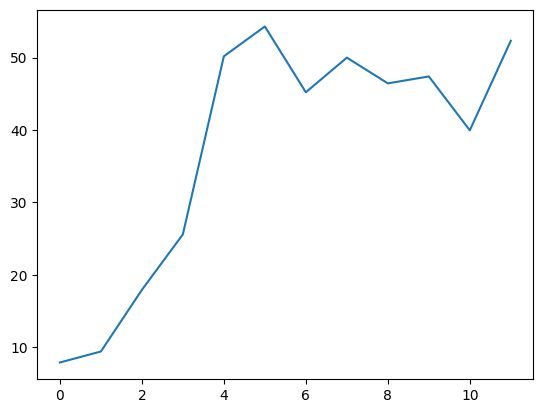

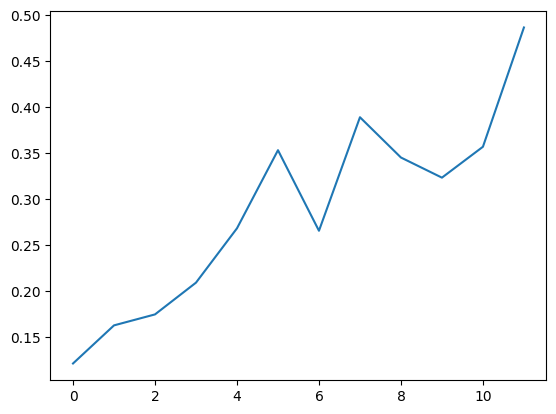

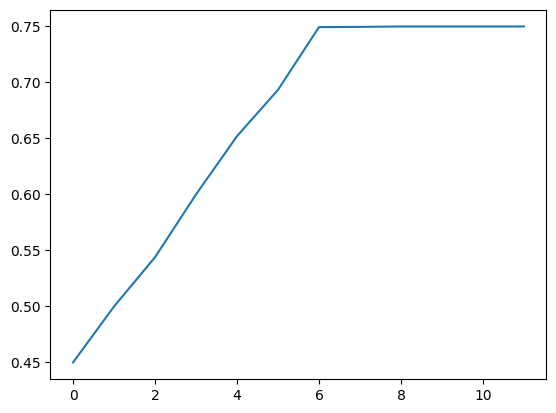

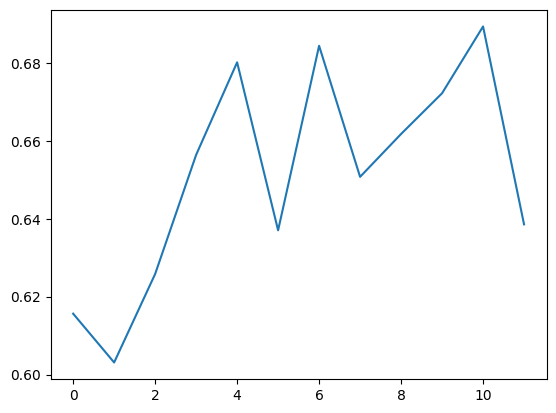

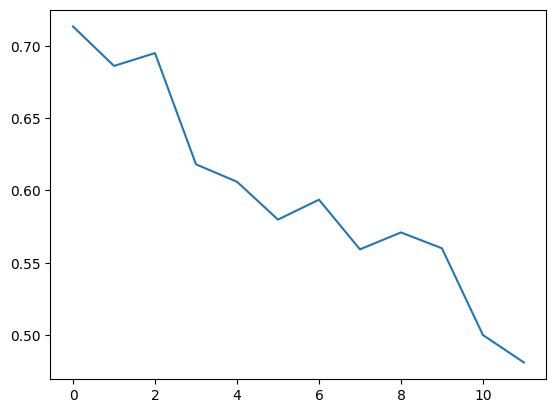

In [83]:
from matplotlib import pyplot as plt
y = [data['y'] for data in dataset]
print(y)
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,0]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,1]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,2]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,3]) for data in dataset]
plt.plot(y)
plt.show()

In [8]:
print(torch.cuda.device_count())  # Number of GPUs available
device = torch.device("cuda:0")  # Select the first GPU (index 0)
print(device)

1
cuda:0


In [290]:
WINDOWS_SIZE = 10

In [291]:
X_list = []
y_list = []
for data in dataset:
    y = data['y']
    n_samples = len(data['xs']) - WINDOWS_SIZE + 1
    # print(n_samples)
    for j in range(n_samples):
        X_list.append(data['xs'][j:j+WINDOWS_SIZE])
        y_list.append(y)

In [292]:
print(len(X_list))
print(len(y_list))

77866
77866


In [293]:
X_torch = torch.tensor(X_list, dtype=torch.float32)
X_torch.shape

torch.Size([77866, 10, 4])

In [294]:
y_torch = torch.tensor(y_list, dtype=torch.float32)
y_torch.shape

torch.Size([77866])

In [282]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    """LSTM unit for regression"""

    def __init__(self, input_size, output_size, hidden_size, num_layers, drop_out=0.1):
        super().__init__()

        self.input_size = input_size    # Number of features per time step
        self.output_size = output_size  # Number of output features
        self.hidden_size = hidden_size  # Size of hidden state
        self.num_layers = num_layers    # Number of LSTM layers
        self.drop_out = drop_out        # Dropout probability

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,           # Input shape: (batch_size, seq_len, input_size)
            dropout=self.drop_out if self.num_layers > 1 else 0.0,  # Dropout only if >1 layer
        )

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, self.output_size),  # Maps hidden state to output
        )

    def forward(self, x):
        """out: [batch_size, seq_len, hidden_size]"""
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))          # LSTM output: (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])             # Take last time step, shape: (batch_size, output_size)
        return out.squeeze(-1)

In [283]:
import dill
model = LSTM(4, 1, 50, 1)
model_stats = summary(model)
print(model_stats)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              11,200
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       51
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0


In [284]:
model.to(device)
model.train(True)

LSTM(
  (lstm): LSTM(4, 50, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [327]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.0000005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00000001, weight_decay=0.00000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000000001, weight_decay=0.00000005)

In [328]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                  mode='min',    # 'min' for minimizing loss
#                                                  factor=0.5,    # Reduce LR by a factor of 0.1
#                                                  patience=30,   # Wait 10 epochs before reducing
#                                                  verbose=True)  # Print when LR changes
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9, verbose=True)

In [329]:
from torch.utils.data import DataLoader, TensorDataset

# Wrap in TensorDataset
tdataset = TensorDataset(X_torch, y_torch)

# Create DataLoader
train_data = DataLoader(tdataset, batch_size=2**14, shuffle=True, drop_last=False)
print(len(train_data))

5


In [330]:
# Training loop
num_epochs = 1000

model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for i, train_data_ in enumerate(train_data, 0):
        inputs, targets = train_data_
        trainX_ = inputs.to(device)
        trainY_ = targets.to(device)
        # print(trainX_.shape)
        
        # Forward pass
        outputs = model(trainX_)
    
        # Compute loss
        loss = criterion(outputs, trainY_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_data)
    # scheduler.step(train_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

Epoch [10/1000], Loss: 0.1170
Epoch [20/1000], Loss: 0.1164
Epoch [30/1000], Loss: 0.1172
Epoch [40/1000], Loss: 0.1172
Epoch [50/1000], Loss: 0.1168
Epoch [60/1000], Loss: 0.1165
Epoch [70/1000], Loss: 0.1172
Epoch [80/1000], Loss: 0.1176
Epoch [90/1000], Loss: 0.1166
Epoch [100/1000], Loss: 0.1170
Epoch [110/1000], Loss: 0.1175
Epoch [120/1000], Loss: 0.1165
Epoch [130/1000], Loss: 0.1167
Epoch [140/1000], Loss: 0.1173
Epoch [150/1000], Loss: 0.1165
Epoch [160/1000], Loss: 0.1167
Epoch [170/1000], Loss: 0.1168
Epoch [180/1000], Loss: 0.1175
Epoch [190/1000], Loss: 0.1165
Epoch [200/1000], Loss: 0.1161
Epoch [210/1000], Loss: 0.1168
Epoch [220/1000], Loss: 0.1170
Epoch [230/1000], Loss: 0.1172
Epoch [240/1000], Loss: 0.1167
Epoch [250/1000], Loss: 0.1169
Epoch [260/1000], Loss: 0.1168
Epoch [270/1000], Loss: 0.1166
Epoch [280/1000], Loss: 0.1170
Epoch [290/1000], Loss: 0.1165
Epoch [300/1000], Loss: 0.1168
Epoch [310/1000], Loss: 0.1166
Epoch [320/1000], Loss: 0.1172
Epoch [330/1000],

77866
torch.Size([779])
torch.Size([779, 10, 4])
(779,)
R² Score: 0.9997


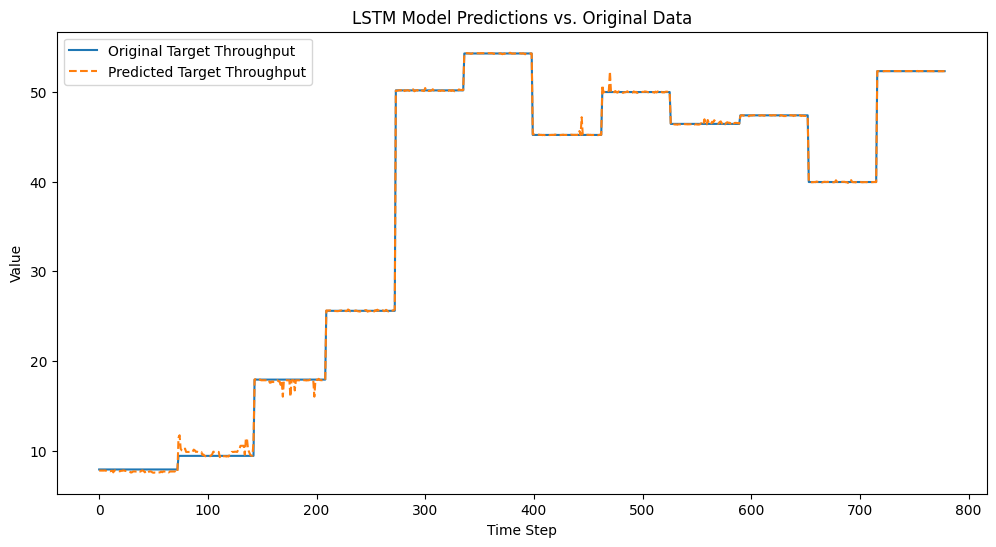

In [331]:
# Predicted outputs
model.eval()
print(len(X_torch))
TEST_START = 30000
TEST_STOP  = 60000

X = X_torch[::100]
predicted = model(X.to(device)).to("cpu")
print(predicted.shape)
print(X.shape)
# print(X_torch[0])
# print(X_torch[9940])

# # Adjusting the original data and prediction for plotting
y = y_torch[::100]  # Original data from the end of the first sequence
time_steps = np.arange(0, len(y))  # Corresponding time steps
print(time_steps.shape)

r2 = r2_score(y, predicted.detach().numpy())
print(f"R² Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y, label='Original Target Throughput')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Target Throughput', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [332]:
torch.save(model, "model_w10_i4_o1_h50_l1.pth", pickle_module=dill)